In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff
from sklearn.linear_model import LinearRegression

In [2]:
DATA_PATH = "../data"
df_merged_ts_meta = pd.read_parquet(DATA_PATH+"/MergedTimeseriesMetadata.parquet",engine="fastparquet")
df_merged_ts_meta["upload_date"] = pd.to_datetime(df_merged_ts_meta["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [3]:
df_merged_ts_meta['tags'] = df_merged_ts_meta['tags'].str.replace("world cup", "world_cup")
df_merged_ts_meta['tags'] = df_merged_ts_meta['tags'].str.replace("table tennis", "table_tennis")
df_merged_ts_meta['tags'] = df_merged_ts_meta['tags'].str.replace("ping pong", "table_tennis")
df_merged_ts_meta['tags'] = df_merged_ts_meta['tags'].str.replace("(football", "football")
df_merged_ts_meta['tags'] = df_merged_ts_meta['tags'].str.replace("(basketball", "basketball")
df_merged_ts_meta['tags'] = df_merged_ts_meta['tags'].str.replace("sp:st=basketball", "basketball")
df_merged_ts_meta['tags'] = df_merged_ts_meta['tags'].str.replace("ski", "skiing")

In [4]:
target_sports = [
    "football","basketball","wrestling","soccer","boxing","hockey","mma","golf","baseball","tennis","cricket","rugby","gymnastics"
,"volleyball","skating","skiing"]

In [5]:
def extract_sport(tags):
    tags_list = tags.lower().split(',')
    for sport in target_sports:
        if sport in tags_list:
            return sport
    return "other"  

df_merged_ts_meta['sport_name'] = df_merged_ts_meta['tags'].apply(extract_sport)

In [19]:
df_merged_ts_meta['sport_name'].value_counts()

sport_name
other         1483350
football       257973
basketball     157325
boxing         107218
wrestling       62548
mma             53106
hockey          44863
baseball        31983
gymnastics      27738
tennis          21953
soccer          20853
golf            20466
cricket         15392
rugby           13082
volleyball      10195
skating          8251
skiing           3995
Name: count, dtype: int64

## FOOTball

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(537776, 2)
(537776, 4)
Missing values
 delta_views        0
treatment_sport    0
FIFA2018           0
interaction        0
dtype: int64


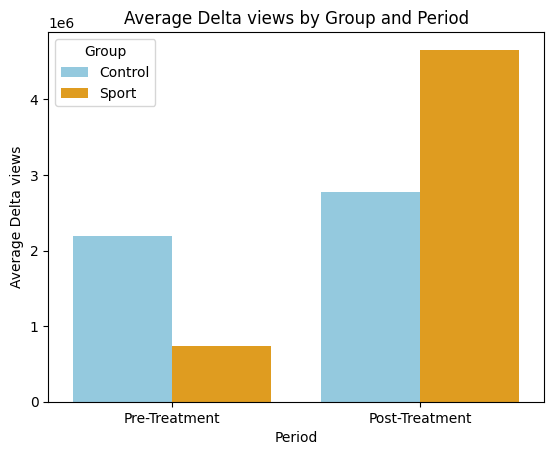

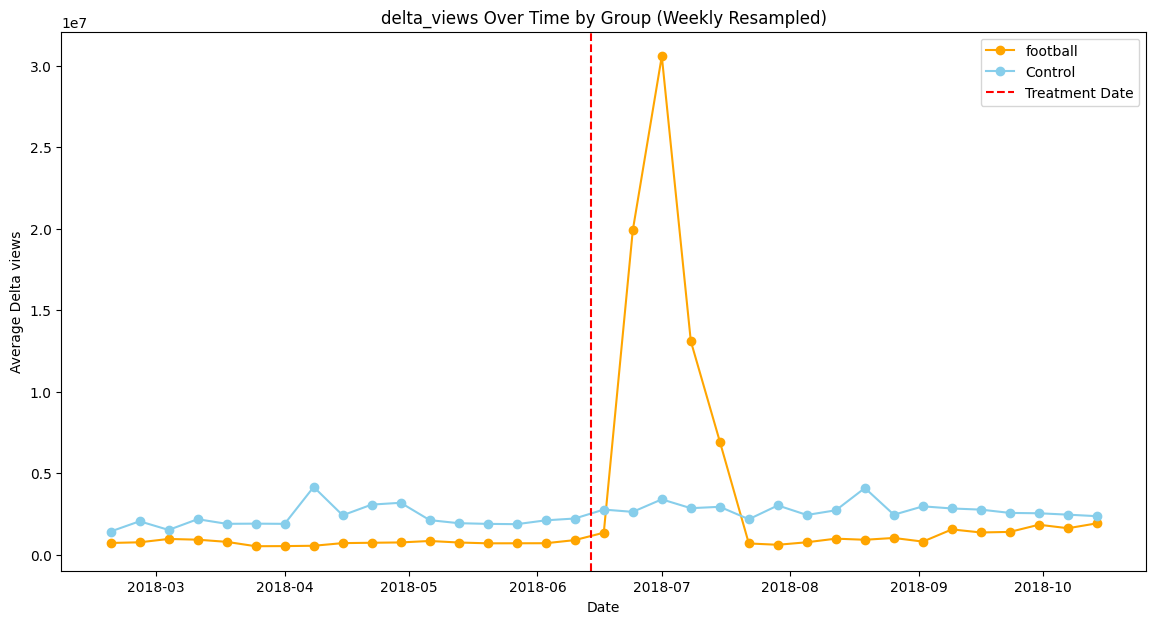

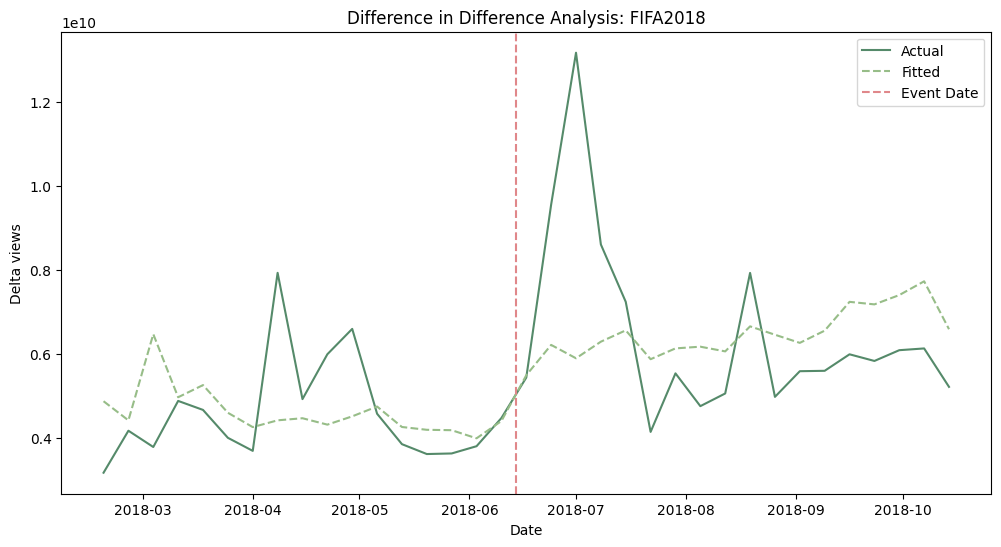

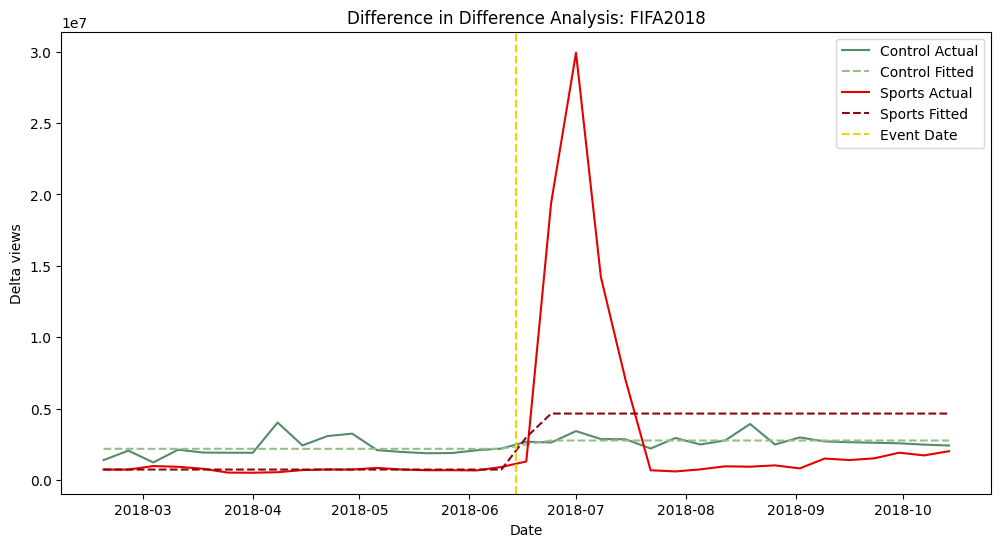

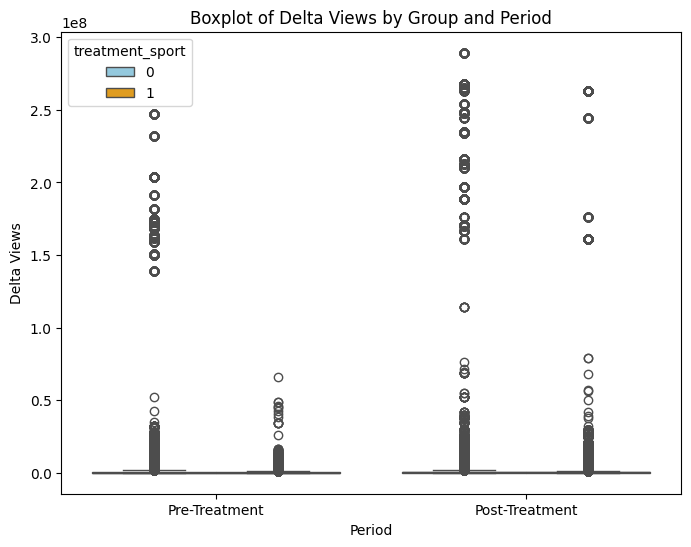

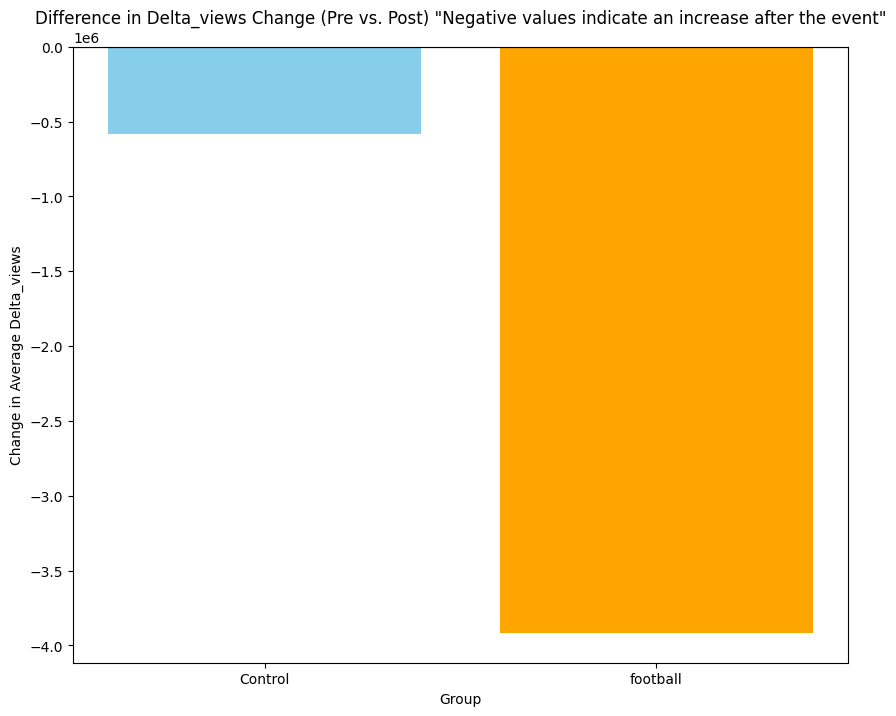

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     264.3
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          1.96e-171
Time:                        21:41:52   Log-Likelihood:            -9.7661e+06
No. Observations:              537776   AIC:                         1.953e+07
Df Residuals:                  537772   BIC:                         1.953e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         2.19e+06   3.78e+04     

In [6]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-06-14')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='FIFA2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='football',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## golf

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(521152, 2)
(521152, 4)
Missing values
 delta_views               0
treatment_sport           0
masters_tornament_2018    0
interaction               0
dtype: int64


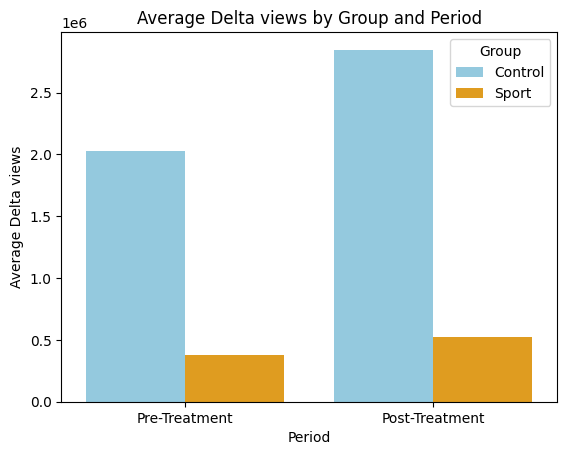

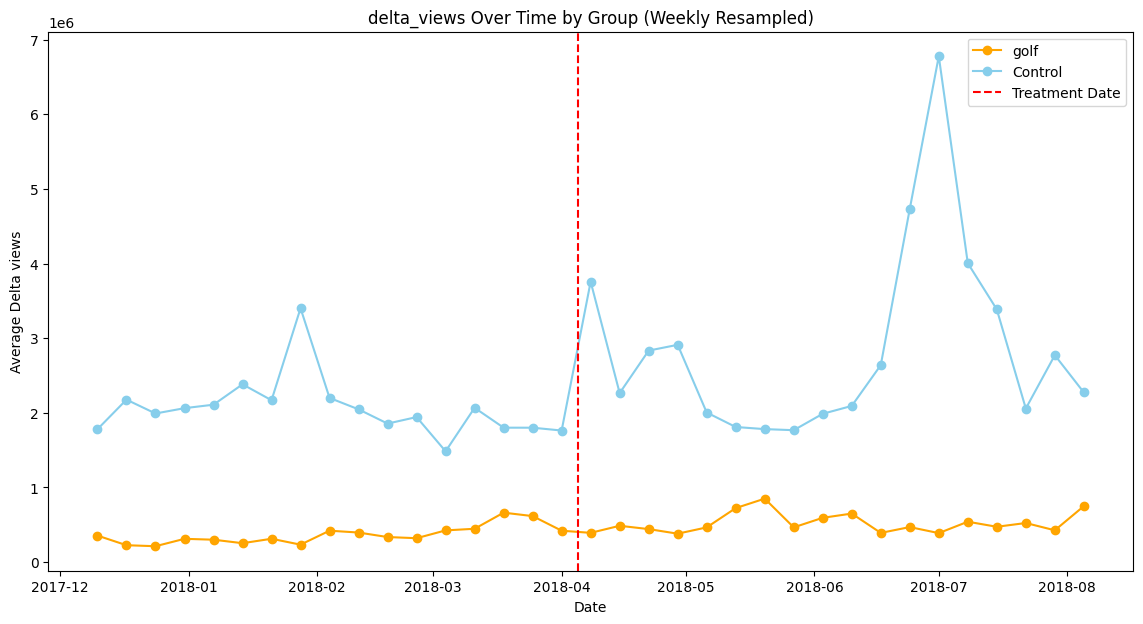

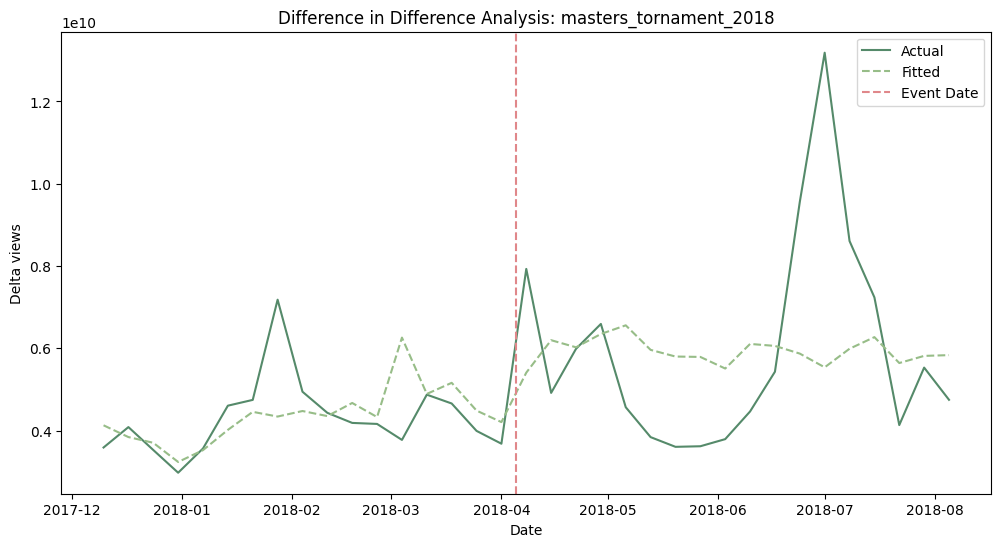

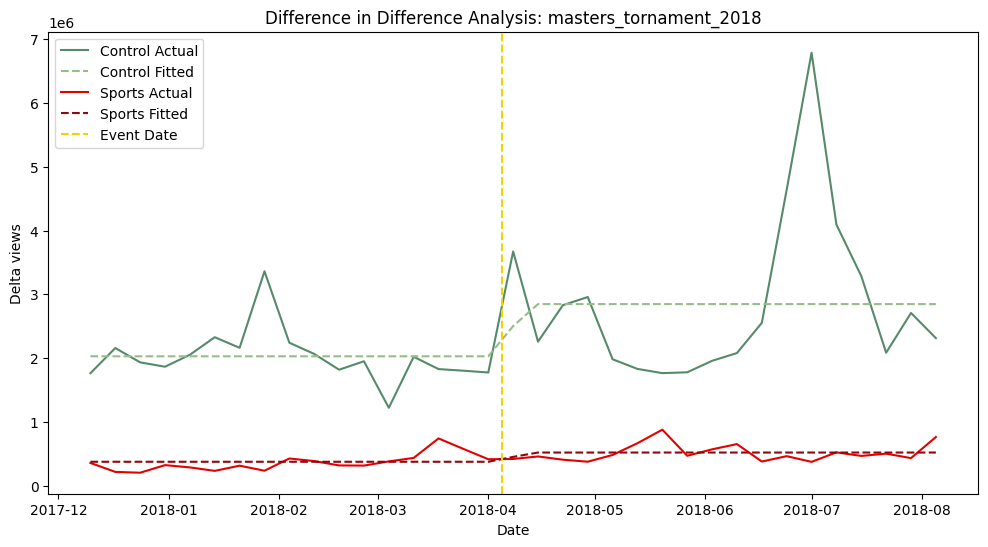

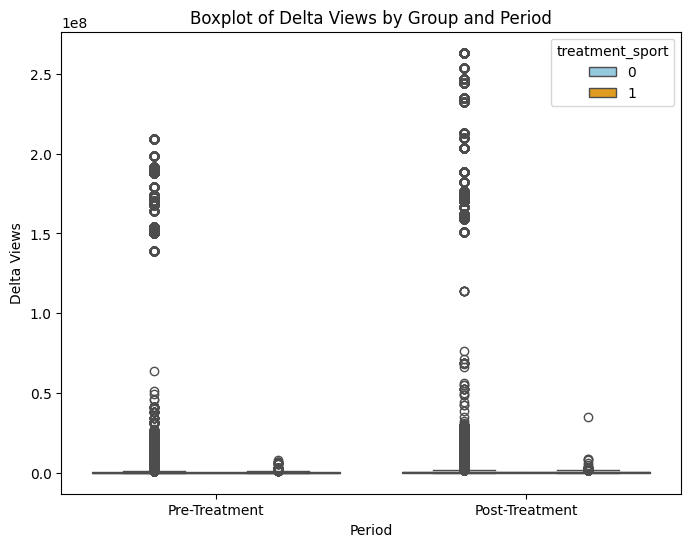

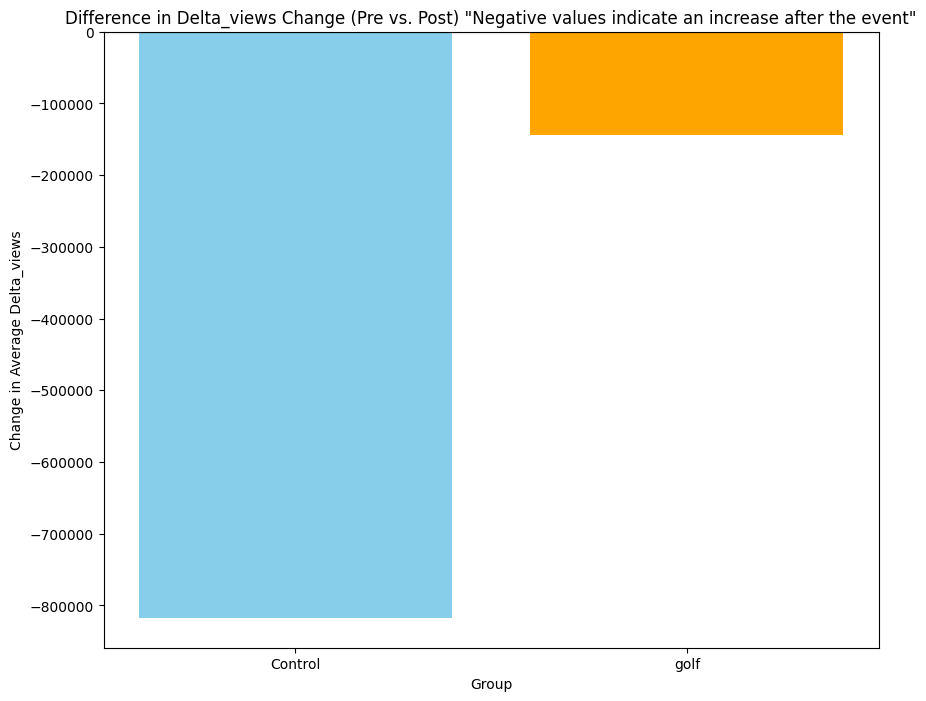

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     113.5
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.85e-73
Time:                        21:42:50   Log-Likelihood:            -9.4276e+06
No. Observations:              521152   AIC:                         1.886e+07
Df Residuals:                  521148   BIC:                         1.886e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                2.0

In [7]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-04-05')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='masters_tornament_2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='golf',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## basketball

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(534393, 2)
(534393, 4)
Missing values
 delta_views        0
treatment_sport    0
NBAfinals2018      0
interaction        0
dtype: int64


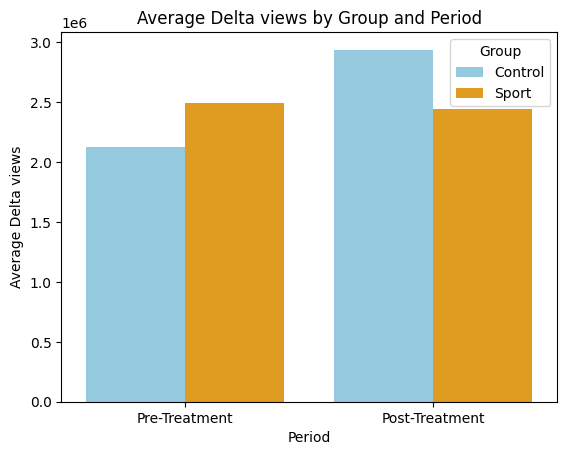

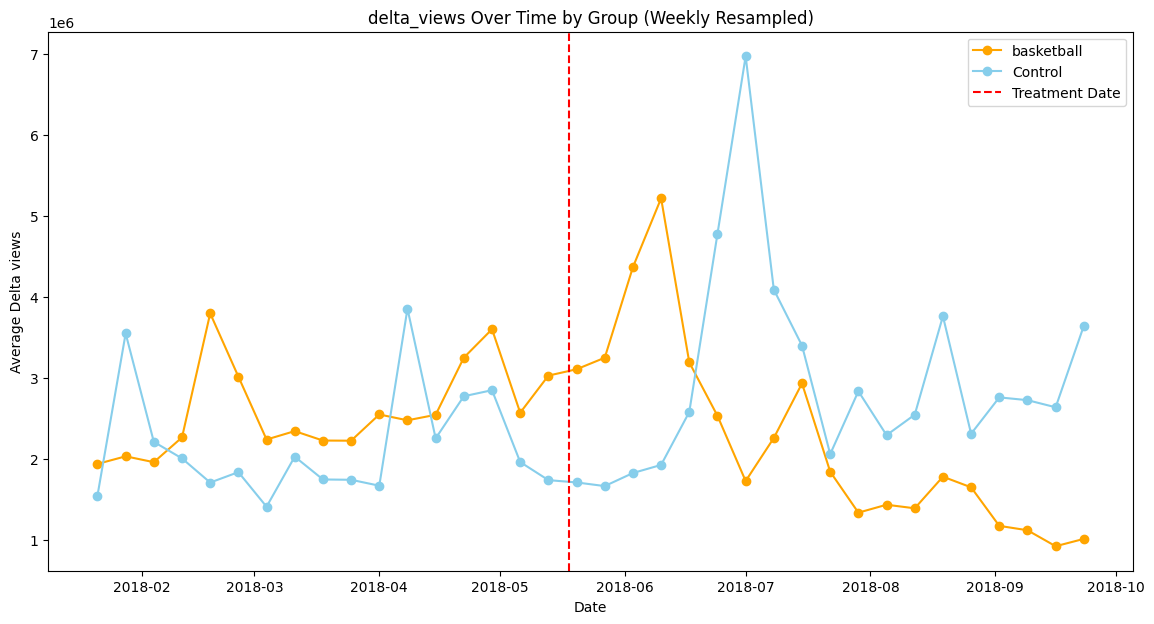

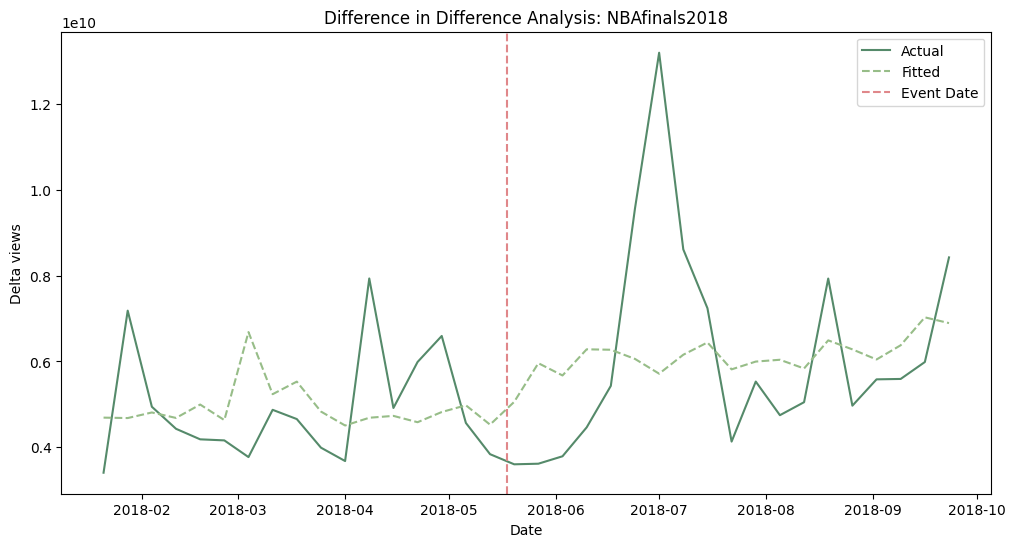

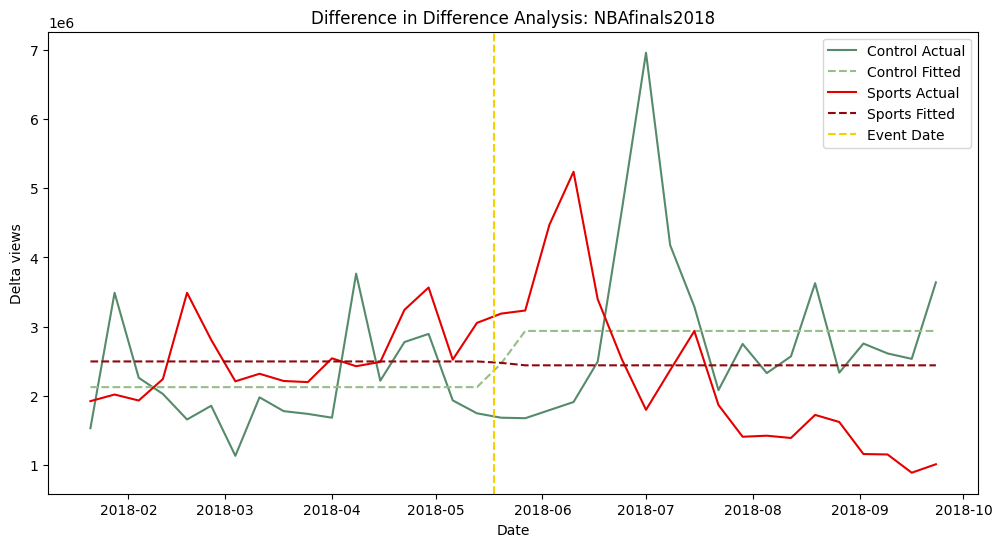

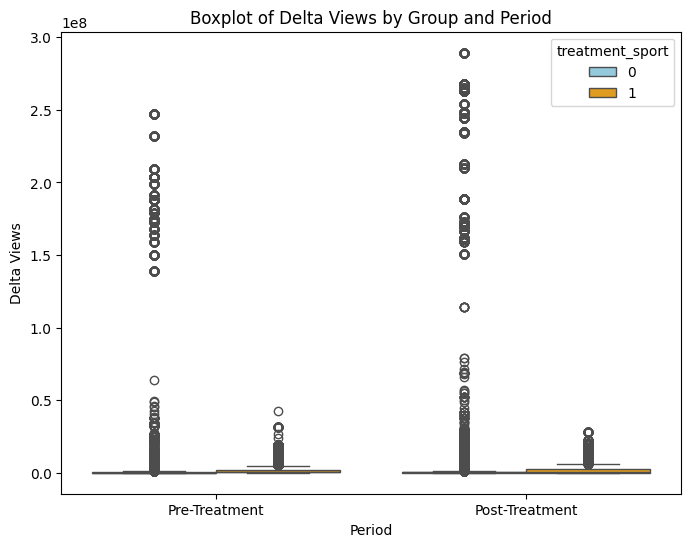

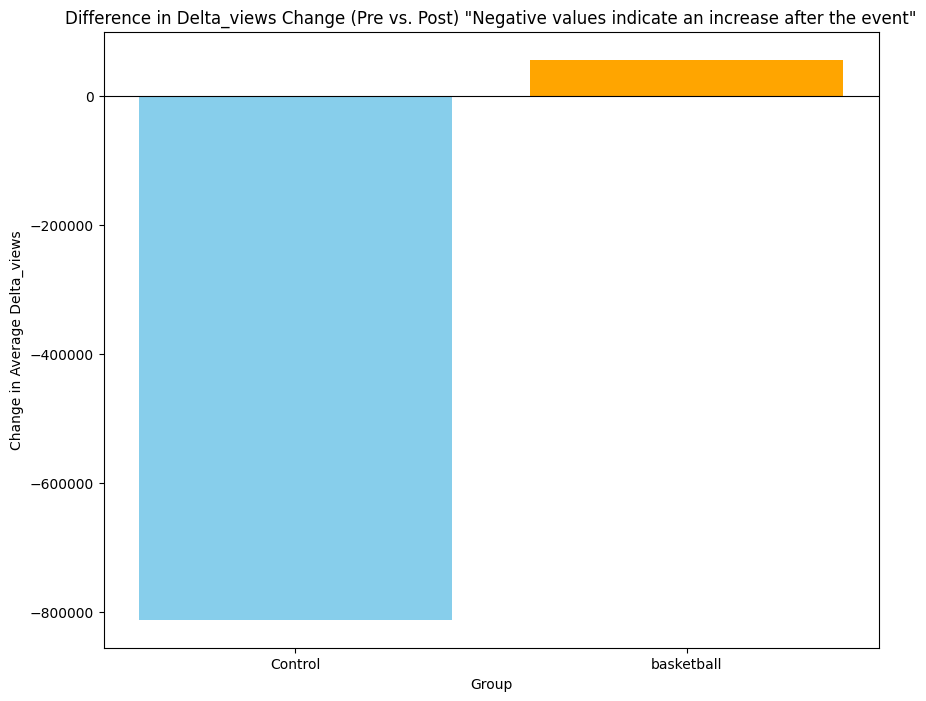

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     78.40
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.07e-50
Time:                        21:45:08   Log-Likelihood:            -9.7070e+06
No. Observations:              534393   AIC:                         1.941e+07
Df Residuals:                  534389   BIC:                         1.941e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.126e+06   3.75e+04     

In [10]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-05-18')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='NBAfinals2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='basketball',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## wrestling

In [ ]:
'2018': {
            'event_name': 'WrestleMania 34',
            'start': datetime(2018, 4, 8),
            'end': datetime(2018, 4, 8),
            'keywords': [
                'WrestleMania 34', 'WrestleMania XXXIV', 'wrestlemania 34', 
                'wrestlemania', 'wwe wrestlemania'
            ]
        }

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(508355, 2)
(508355, 4)
Missing values
 delta_views        0
treatment_sport    0
WrestleMania34     0
interaction        0
dtype: int64


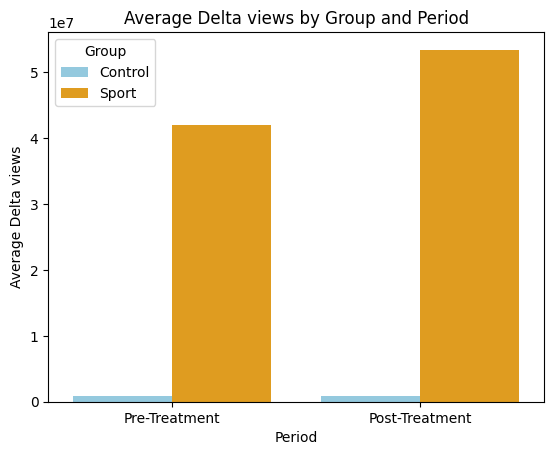

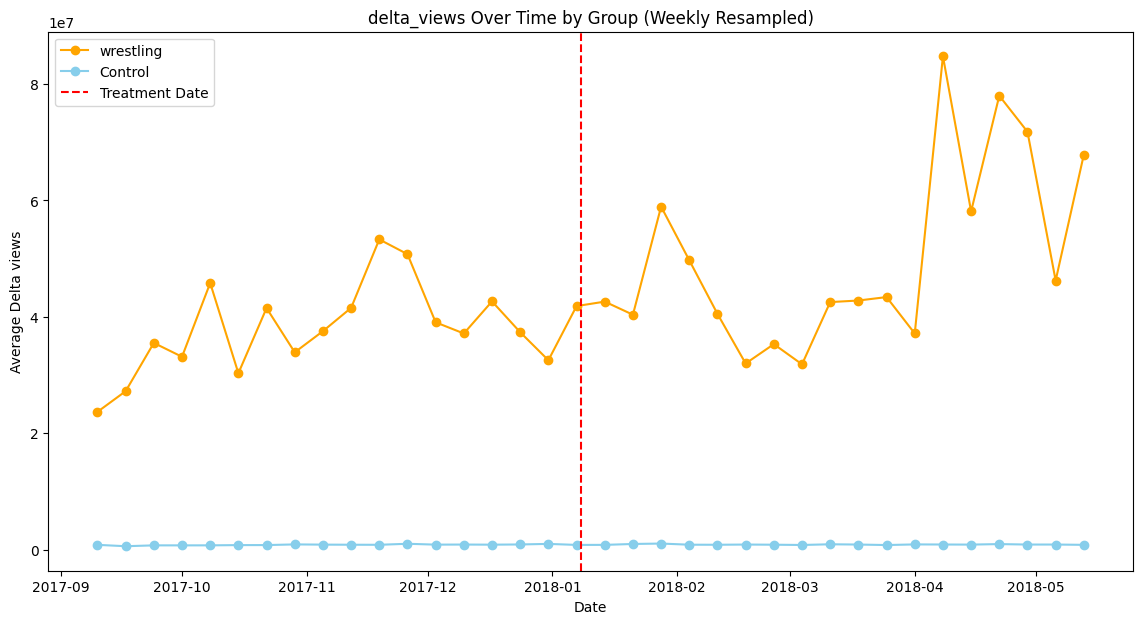

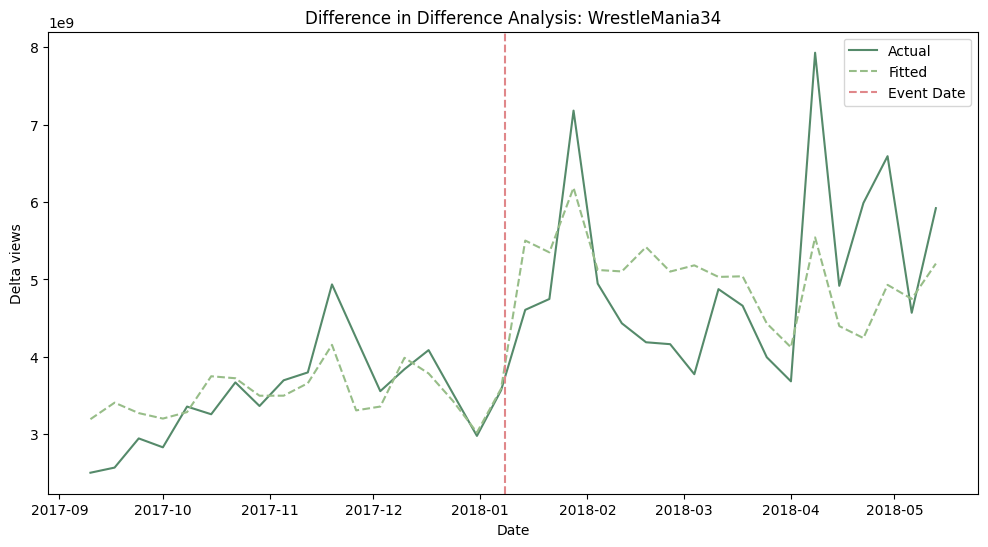

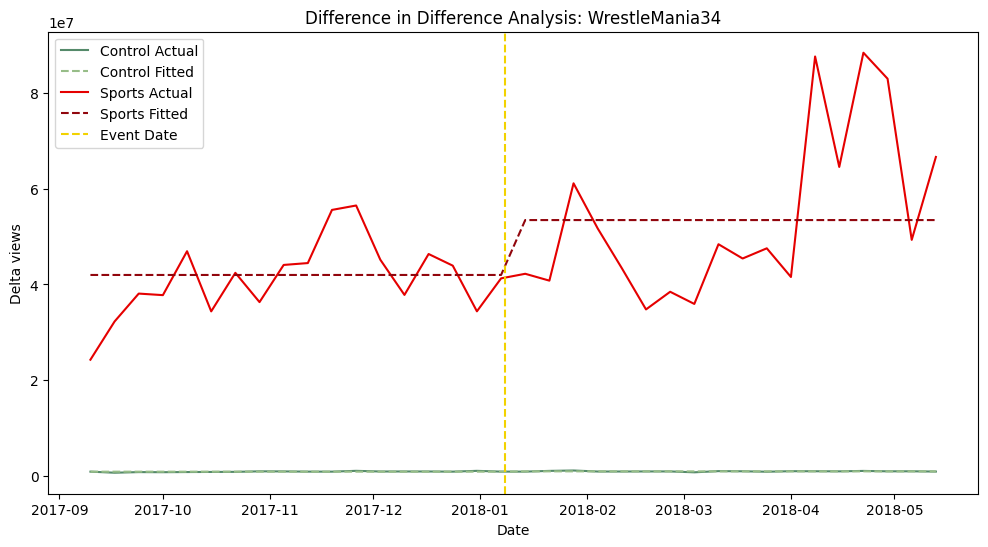

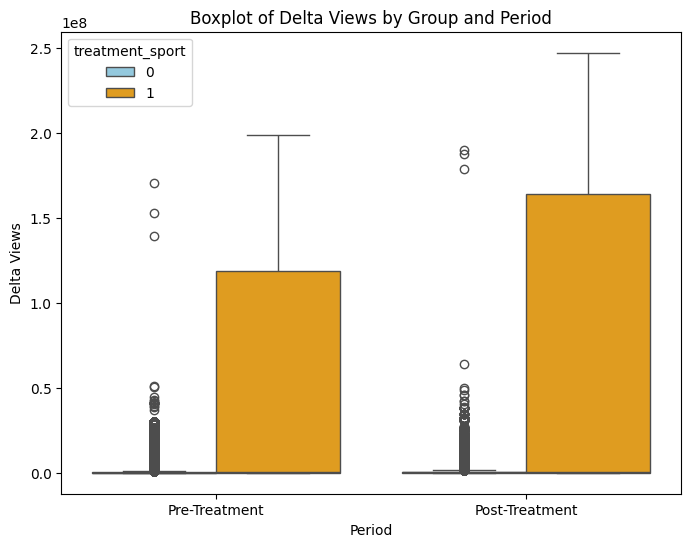

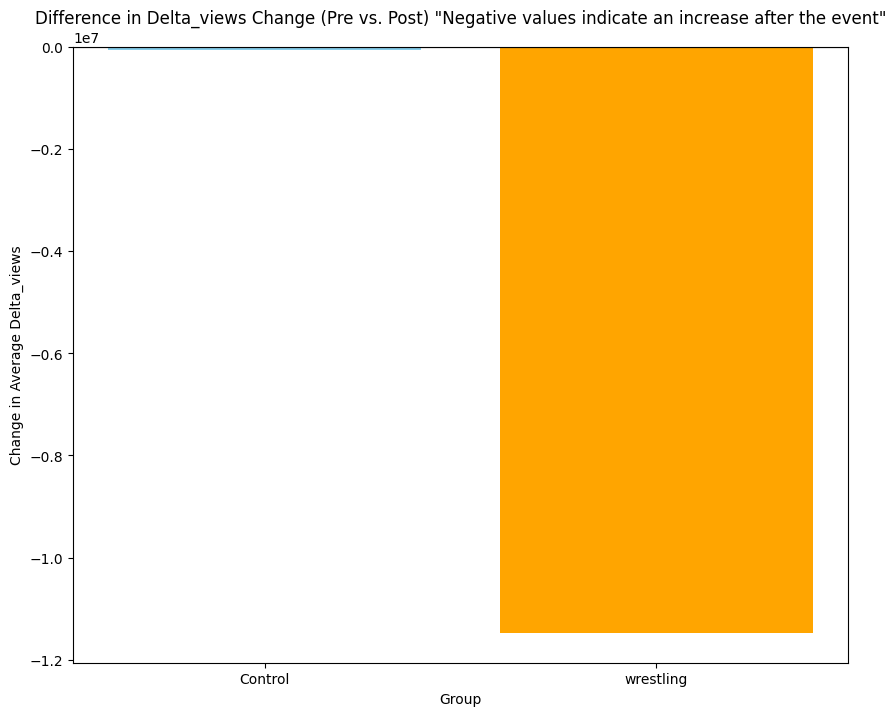

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                 6.216e+04
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:50:42   Log-Likelihood:            -9.0183e+06
No. Observations:              508355   AIC:                         1.804e+07
Df Residuals:                  508351   BIC:                         1.804e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.326e+05   2.57e+04     

In [11]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-01-08')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='WrestleMania34',            # イベントを示す列（0/1のフラグ列）
             sport_name='wrestling',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## hockey

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(537103, 2)
(537103, 4)
Missing values
 delta_views             0
treatment_sport         0
StanleyCupFinals2018    0
interaction             0
dtype: int64


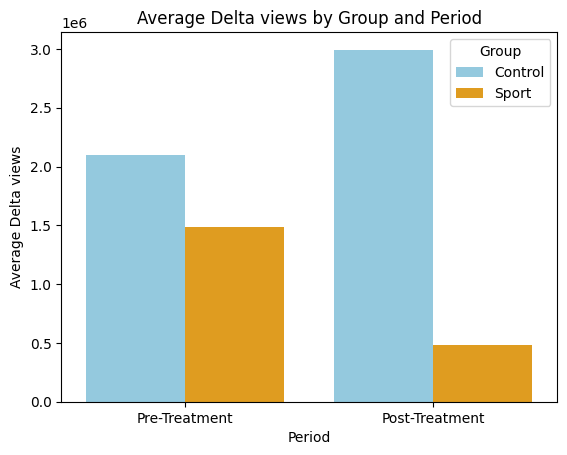

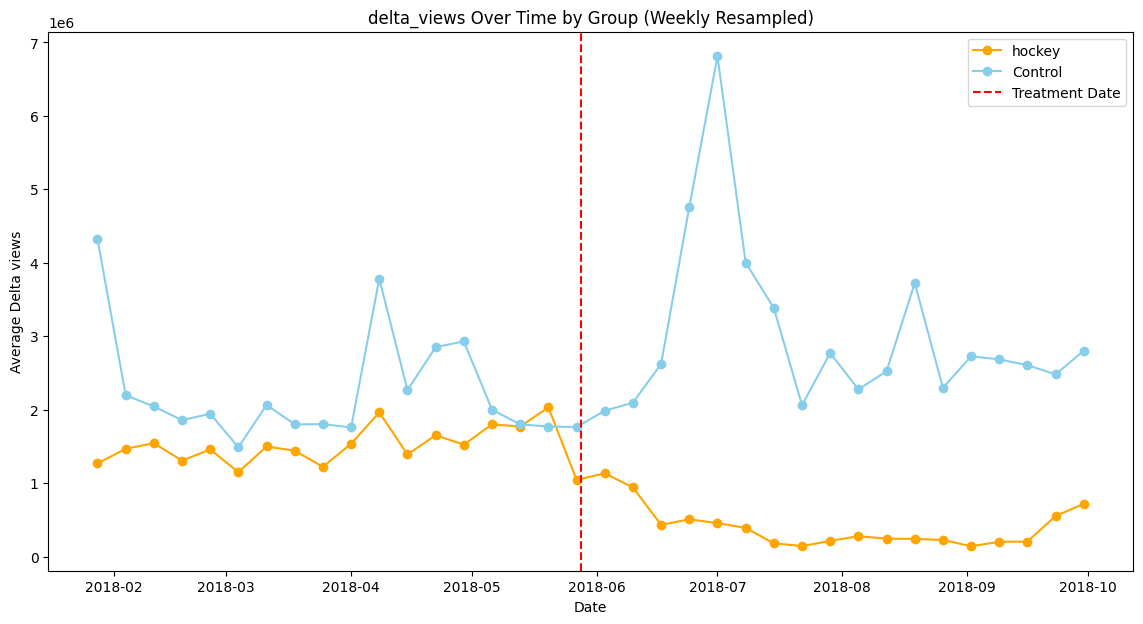

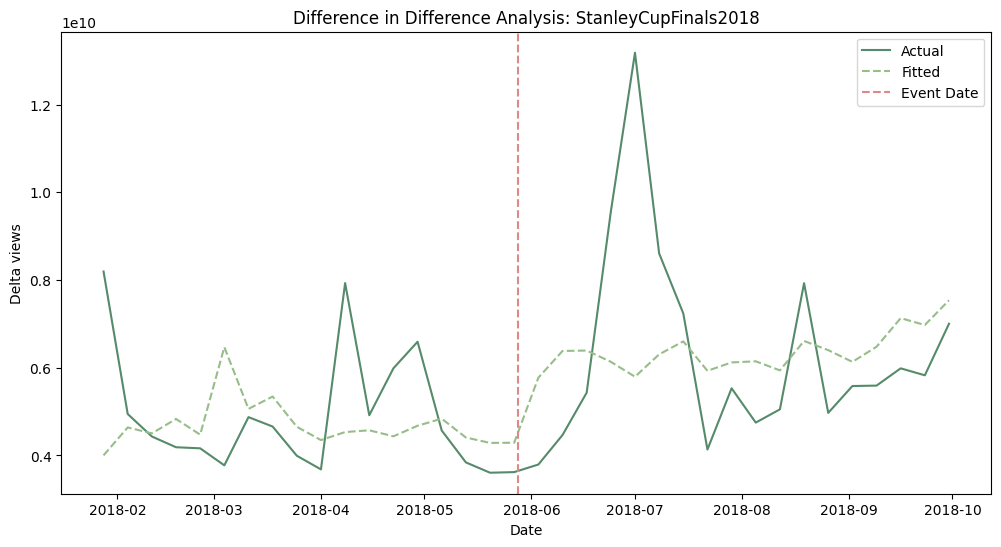

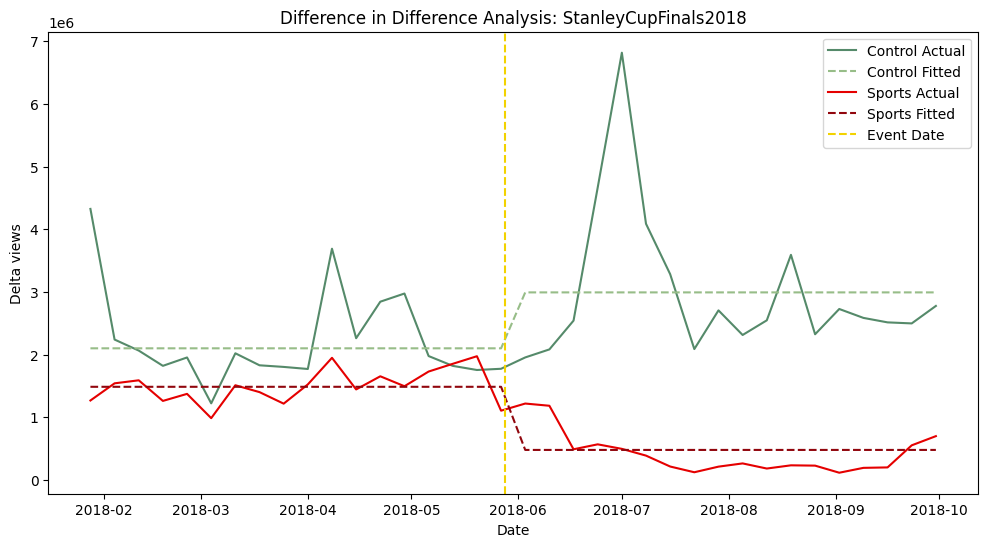

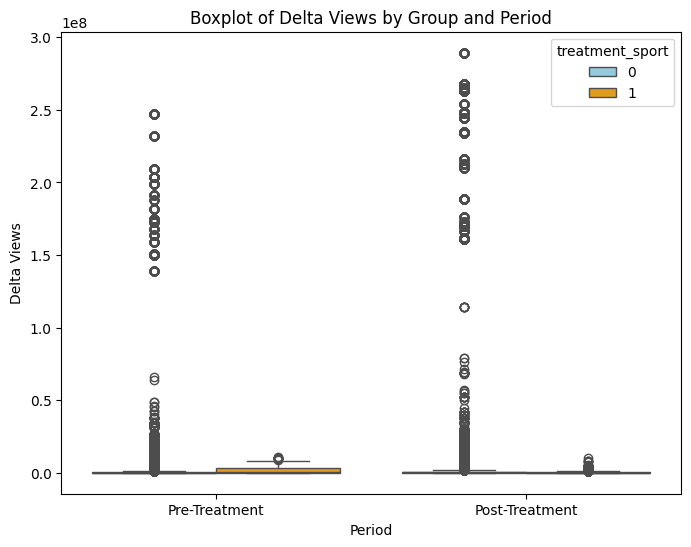

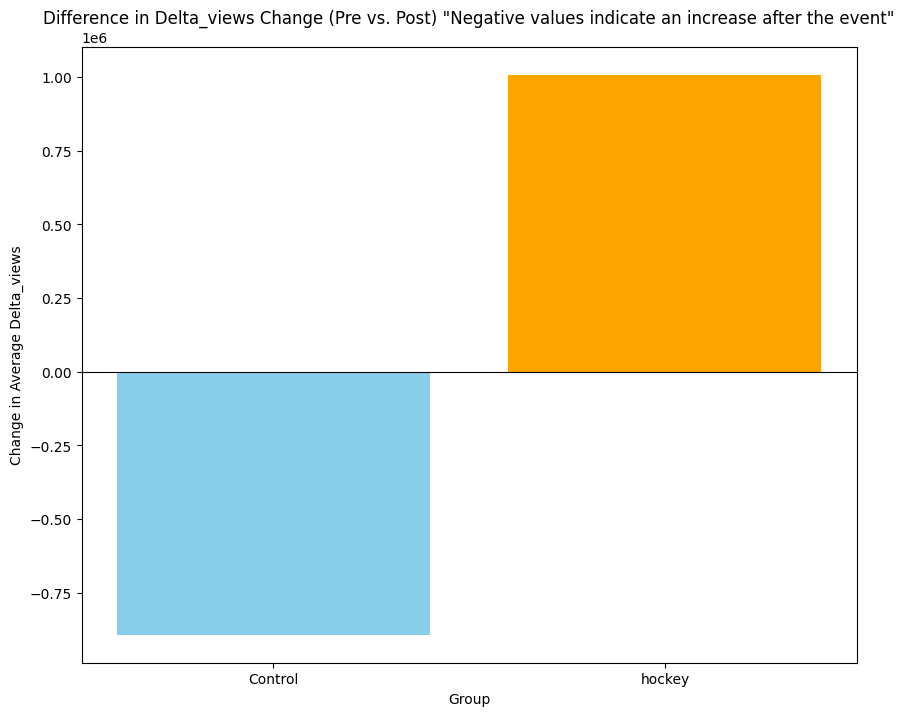

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     116.0
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           4.57e-75
Time:                        21:54:21   Log-Likelihood:            -9.7577e+06
No. Observations:              537103   AIC:                         1.952e+07
Df Residuals:                  537099   BIC:                         1.952e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.101e+06 

In [14]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-05-28')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='StanleyCupFinals2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='hockey',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## skiing

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(517870, 2)
(517870, 4)
Missing values
 delta_views            0
treatment_sport        0
WinterOnlynpics2018    0
interaction            0
dtype: int64


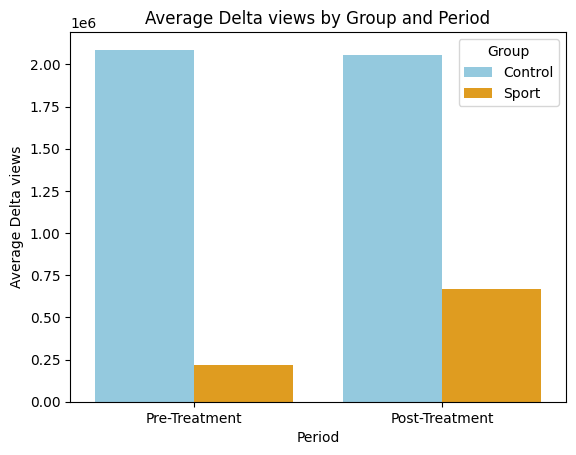

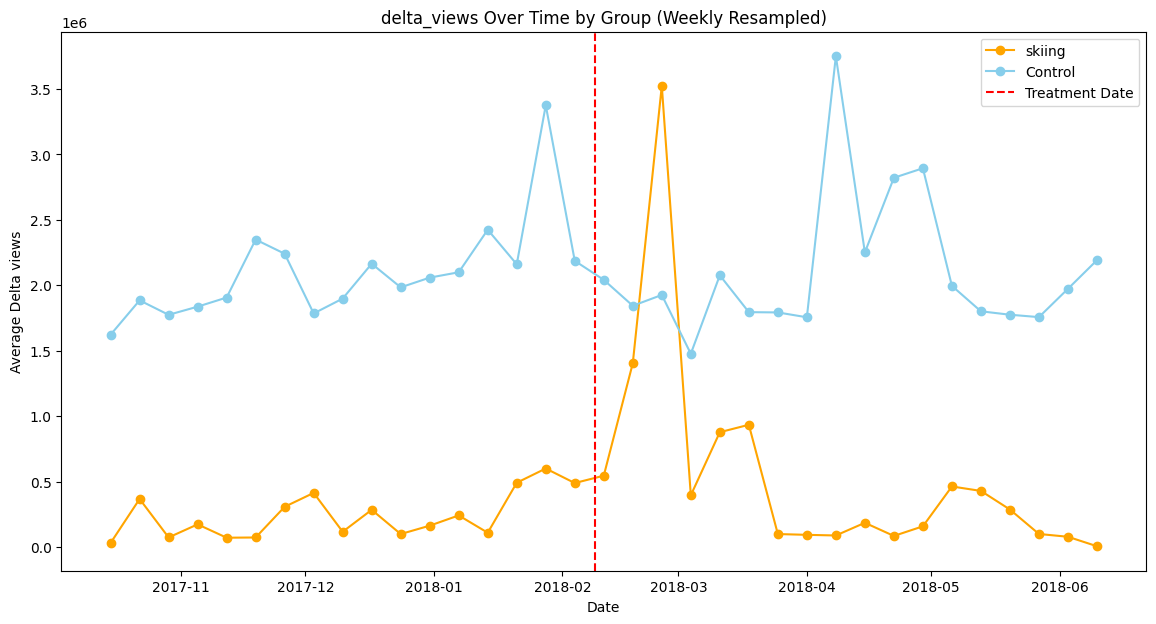

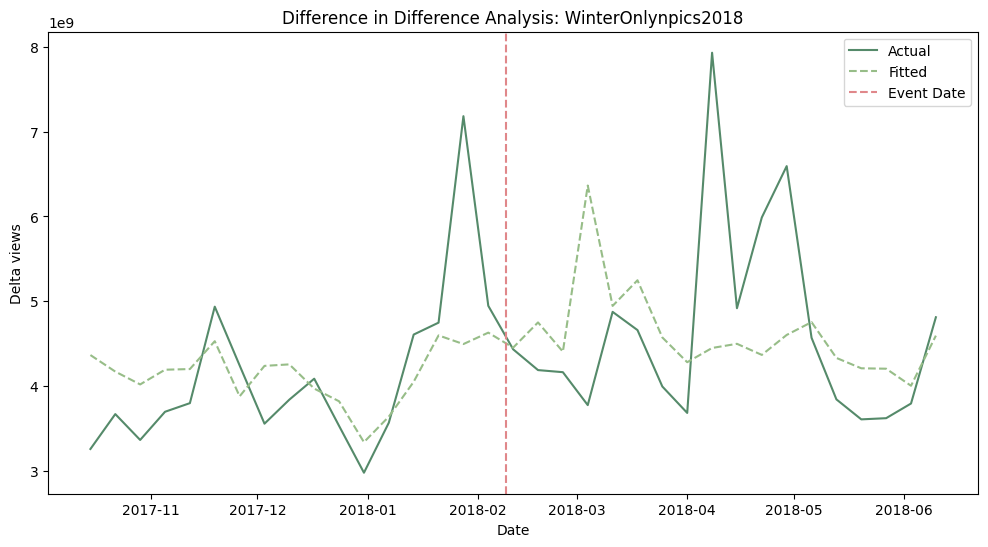

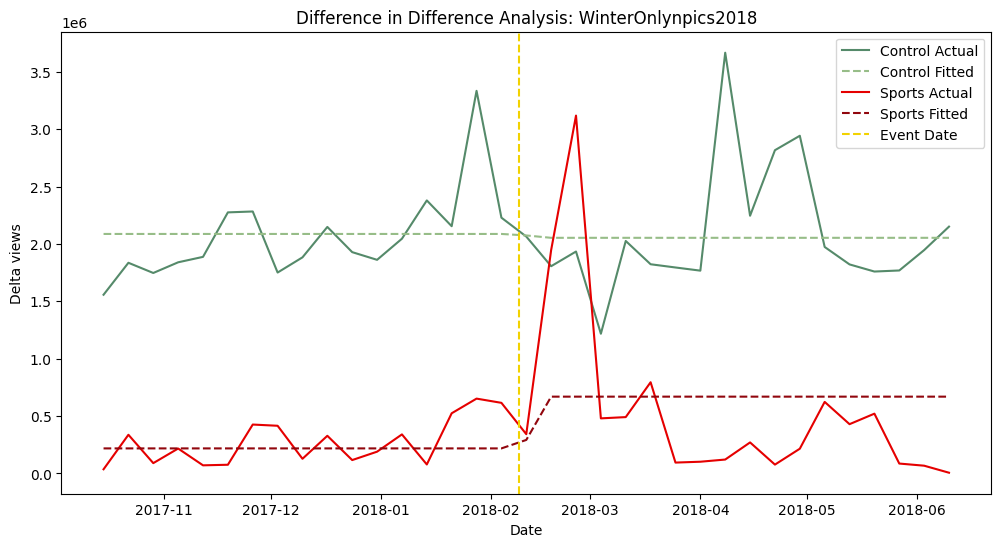

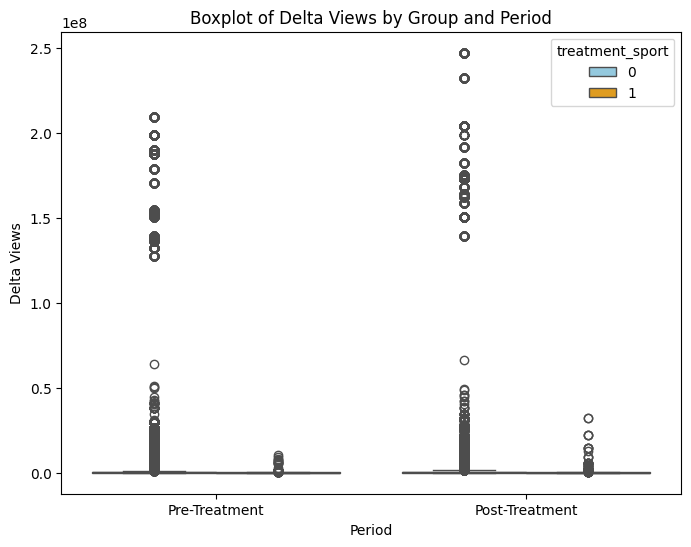

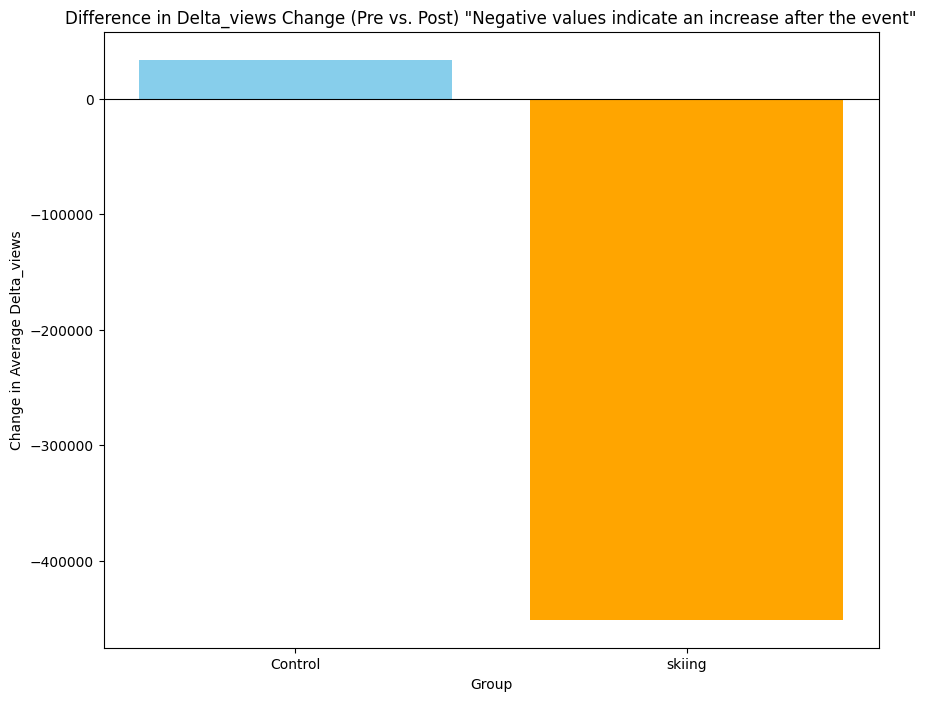

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.398
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           5.94e-05
Time:                        21:51:36   Log-Likelihood:            -9.2747e+06
No. Observations:              517870   AIC:                         1.855e+07
Df Residuals:                  517866   BIC:                         1.855e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.087e+06   2

In [13]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-02-09')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='WinterOnlynpics2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='skiing',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## skating

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(517870, 2)
(517870, 4)
Missing values
 delta_views            0
treatment_sport        0
WinterOnlynpics2018    0
interaction            0
dtype: int64


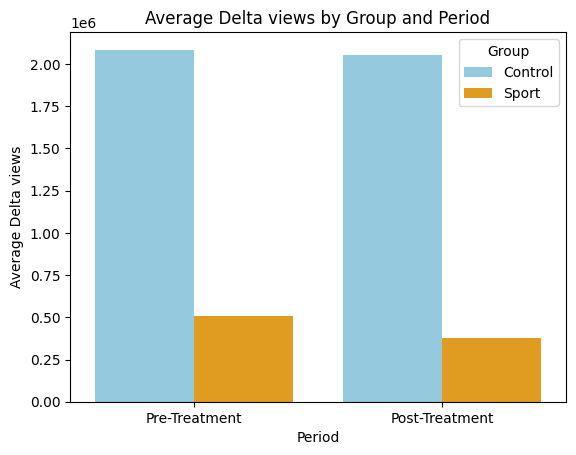

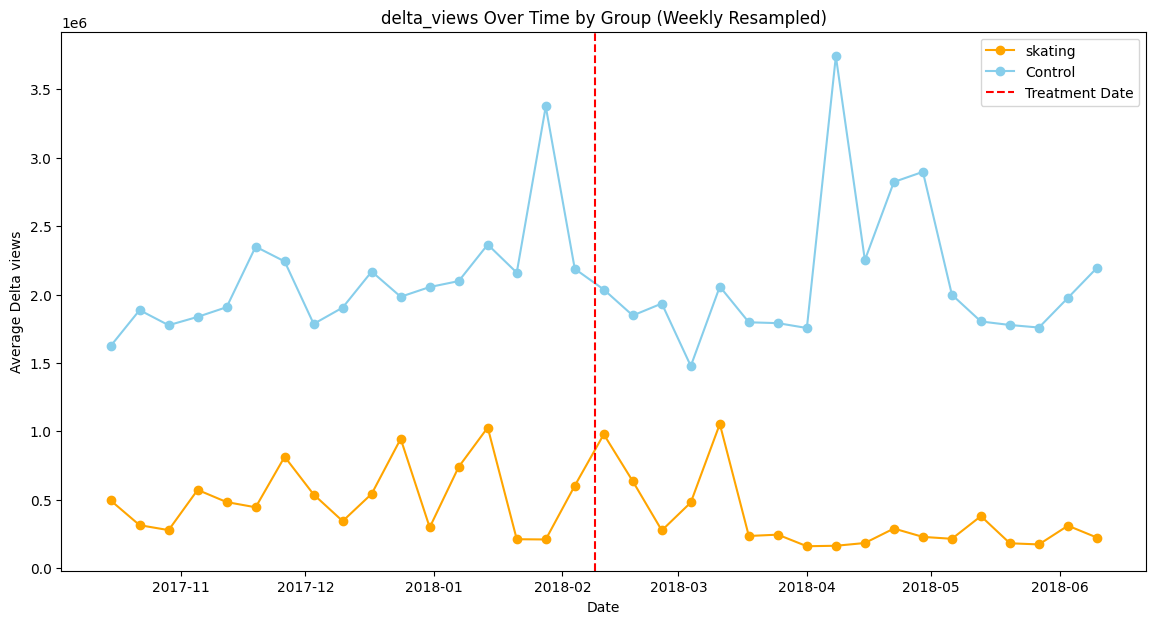

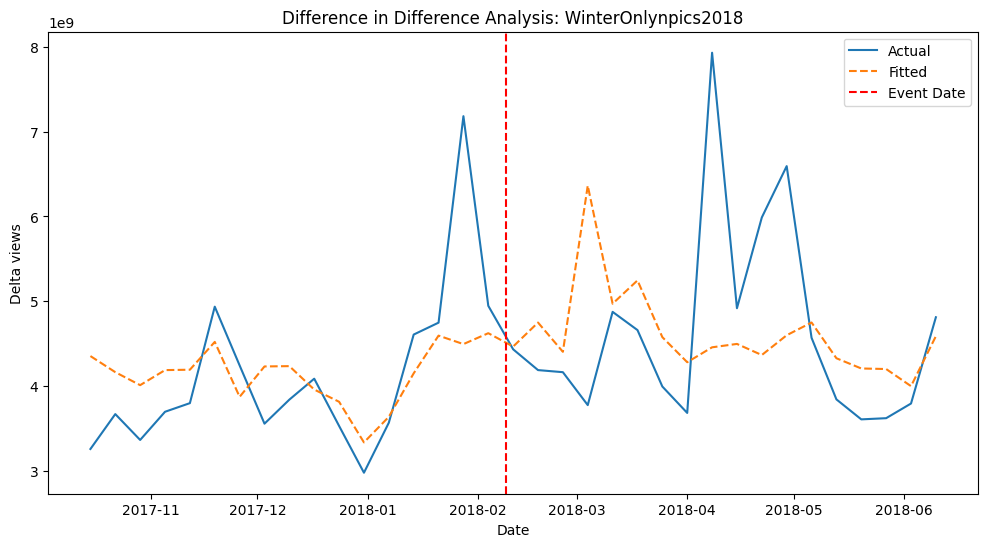

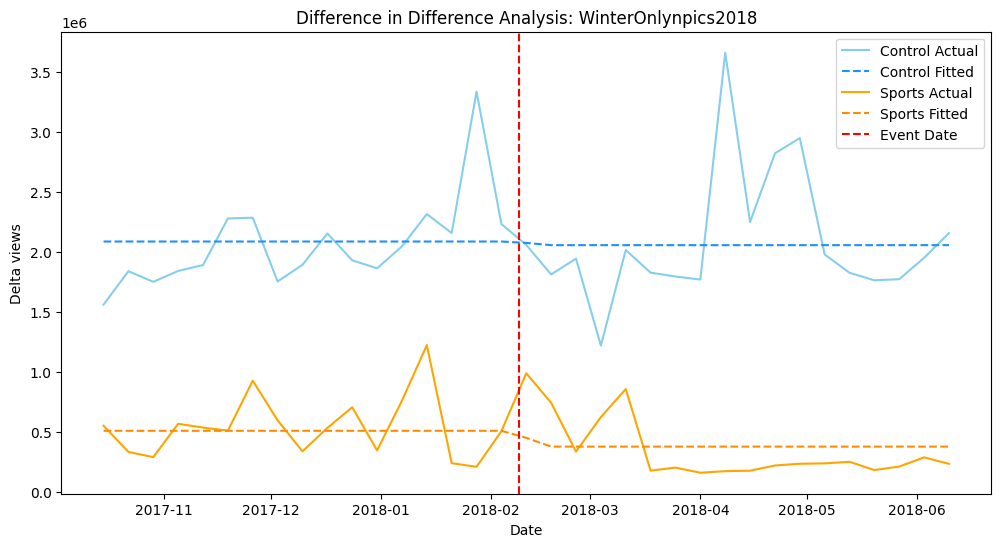

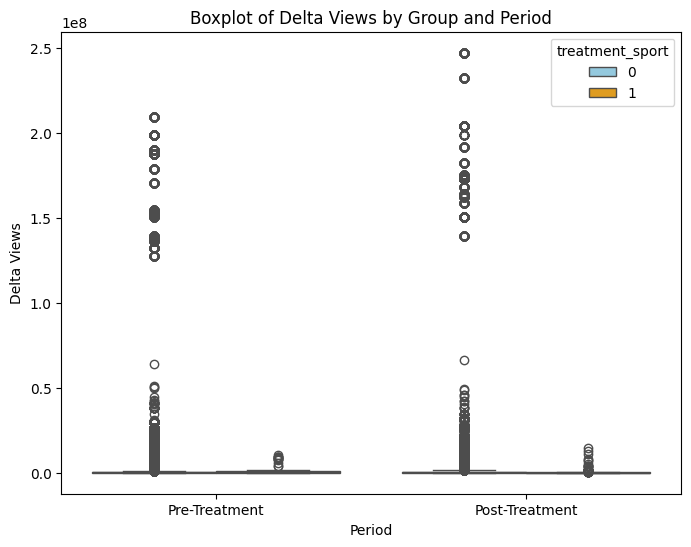

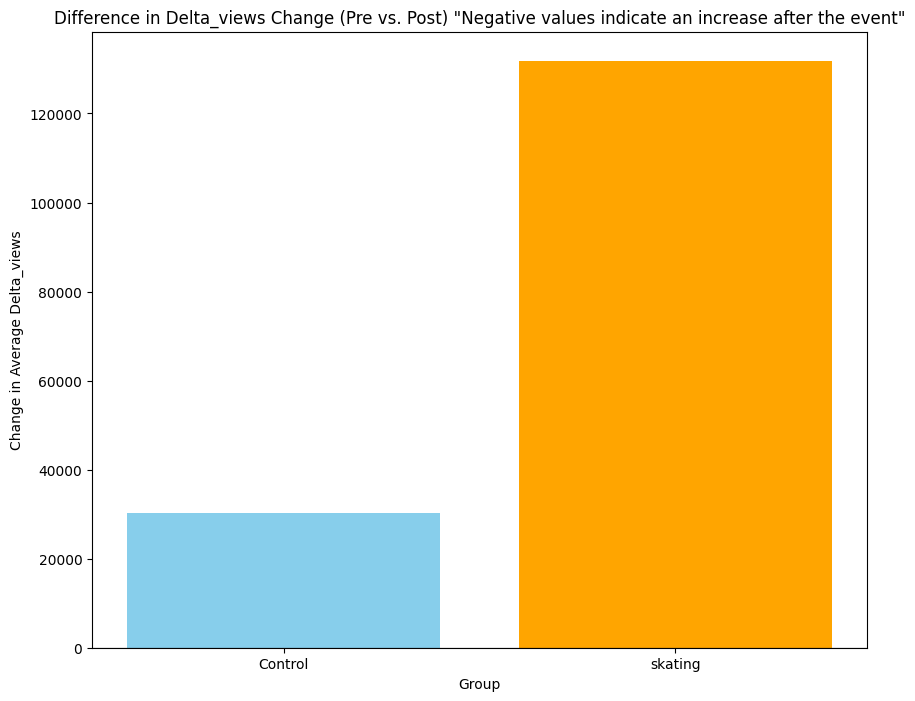

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.504
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           0.000890
Time:                        21:04:40   Log-Likelihood:            -9.2747e+06
No. Observations:              517870   AIC:                         1.855e+07
Df Residuals:                  517866   BIC:                         1.855e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.084e+06   2

In [12]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-02-09')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='WinterOnlynpics2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='skating',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## gymnastics

In [ ]:
'2018': {
            'event_name': '2018 World Artistic Gymnastics Championships',
            'start': datetime(2018, 10, 28),
            'end': datetime(2018, 11, 4),
            'keywords': [
                '2018 World Artistic Gymnastics Championships', 
                'World Gymnastics Championships 2018', 'gymnastics world championships', 
                'artistic gymnastics 2018', 'gymnastics championships'
            ]
        }

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(567473, 2)
(567473, 4)
Missing values
 delta_views                                 0
treatment_sport                             0
WorldArtisticGymnasticsChampionships2018    0
interaction                                 0
dtype: int64


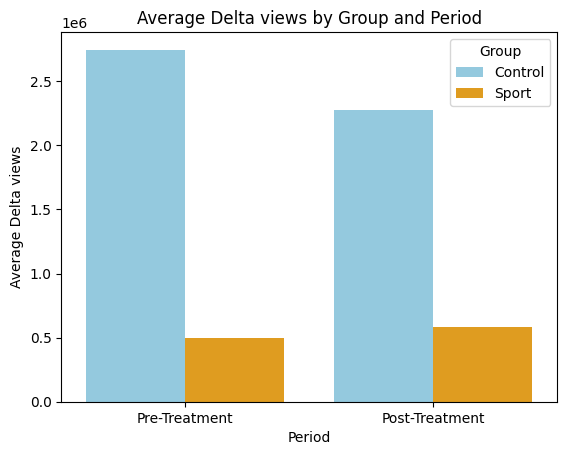

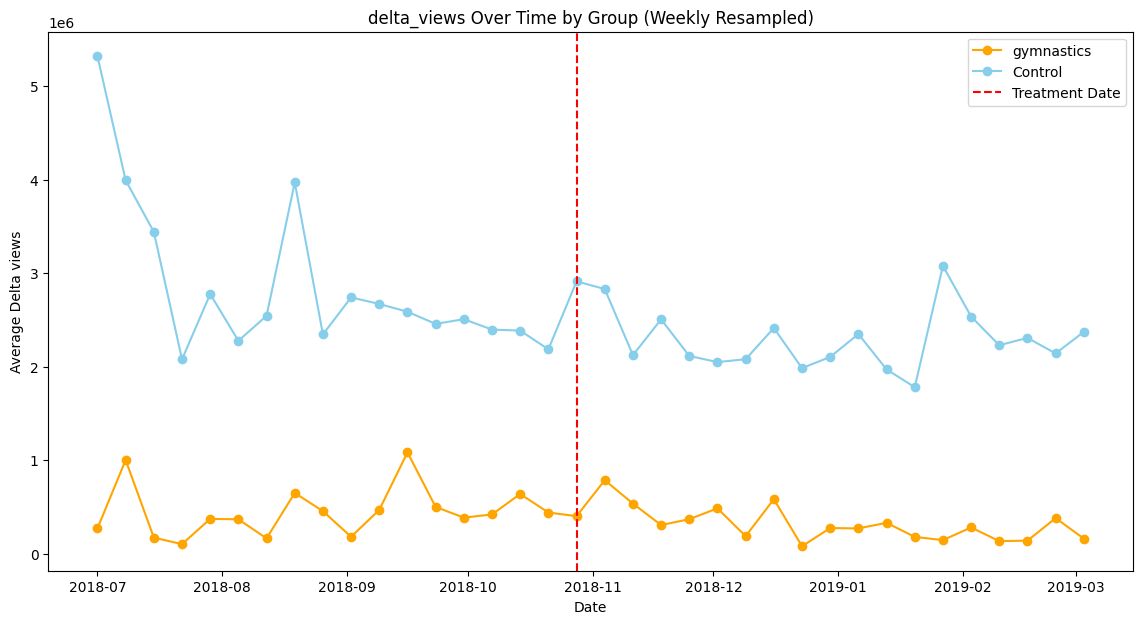

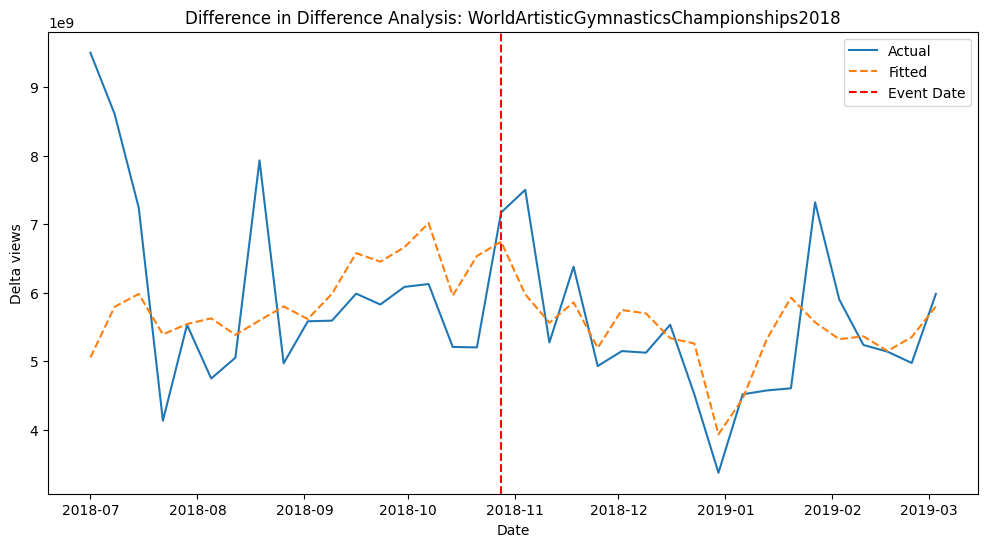

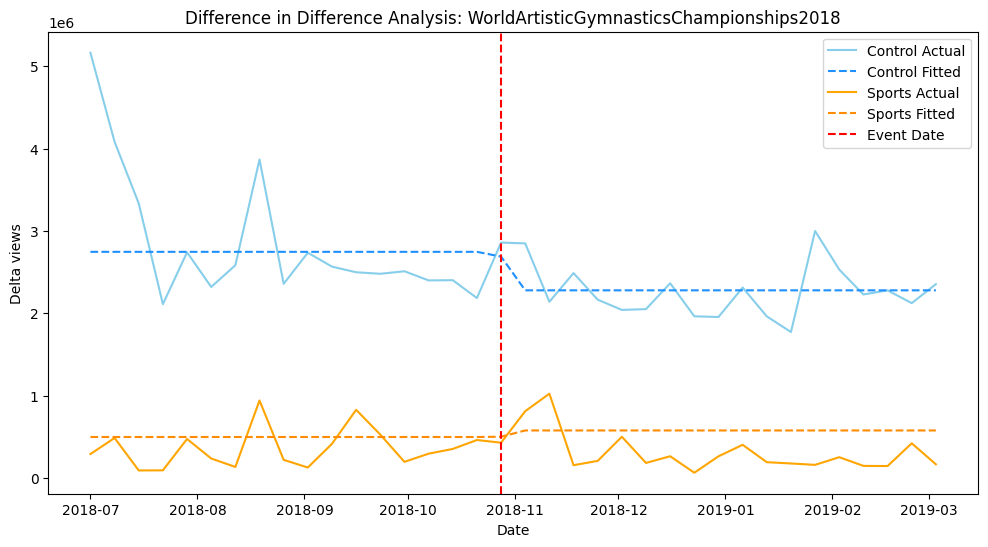

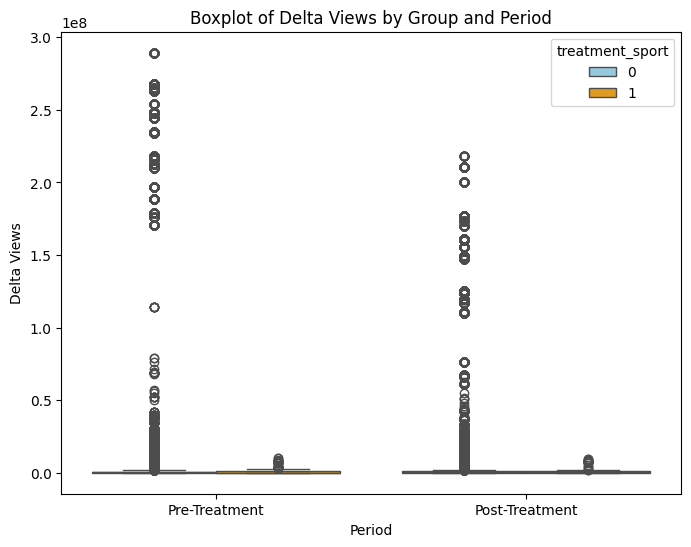

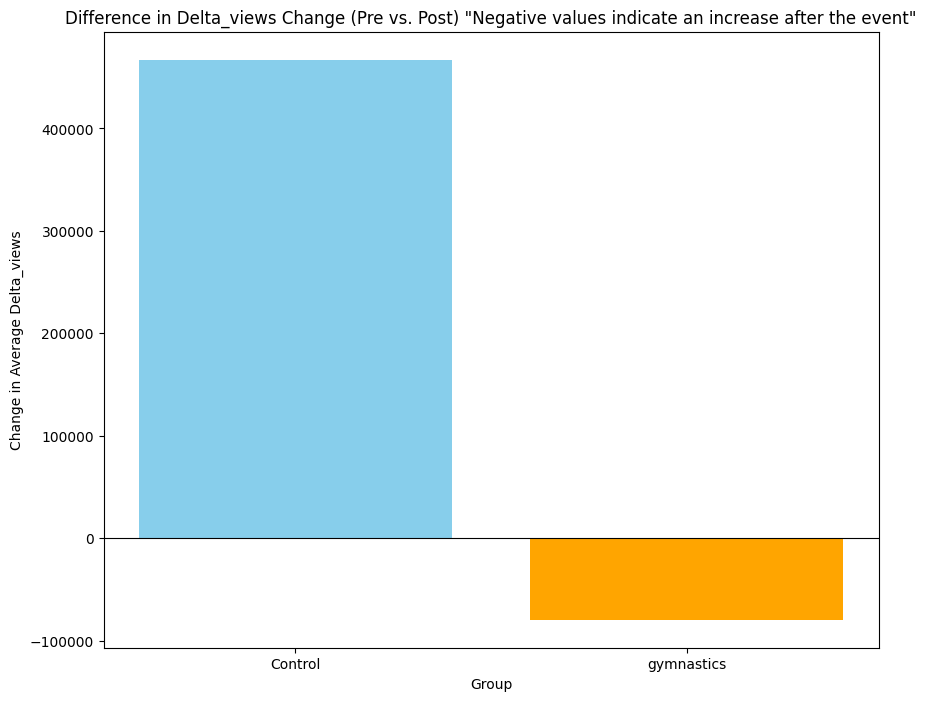

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     80.62
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           3.85e-52
Time:                        21:04:43   Log-Likelihood:            -1.0255e+07
No. Observations:              567473   AIC:                         2.051e+07
Df Residuals:                  567469   BIC:                         2.051e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [13]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-10-28')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='WorldArtisticGymnasticsChampionships2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='gymnastics',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## tennis

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(543630, 2)
(543630, 4)
Missing values
 delta_views        0
treatment_sport    0
Wimbledon2018      0
interaction        0
dtype: int64


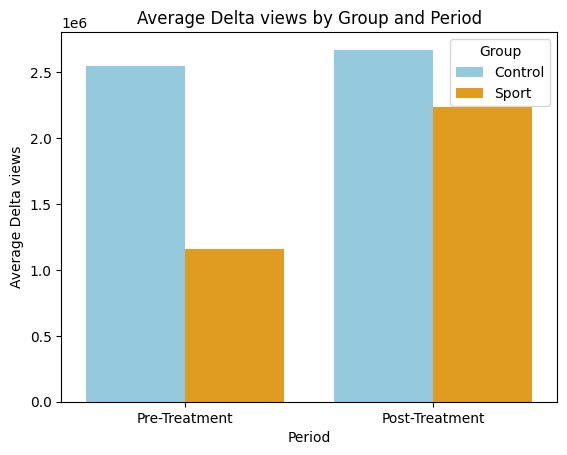

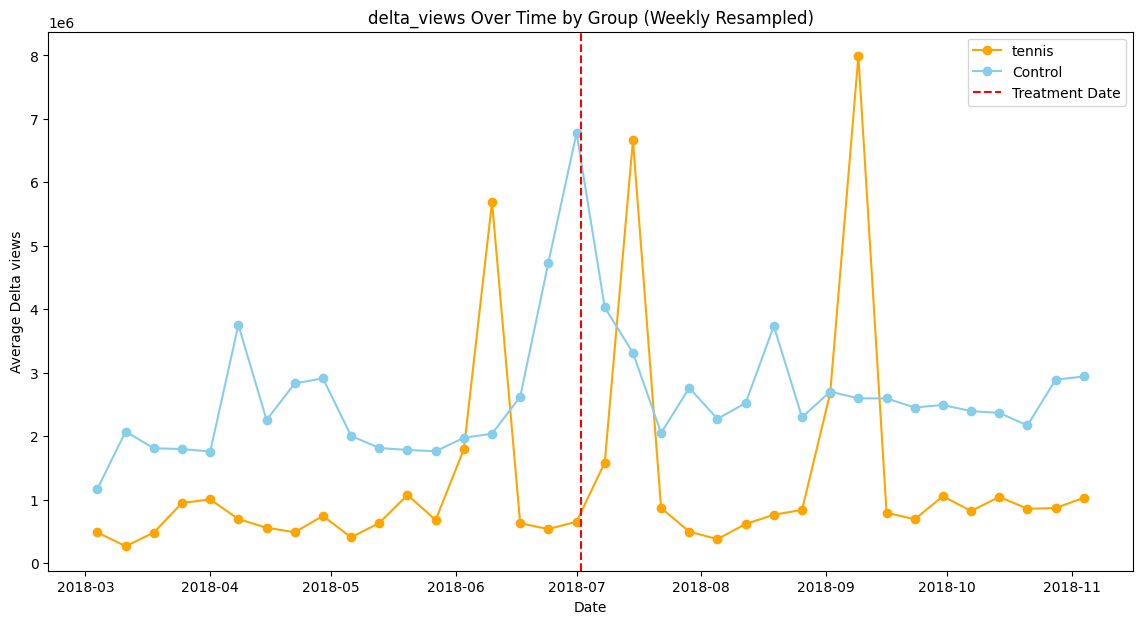

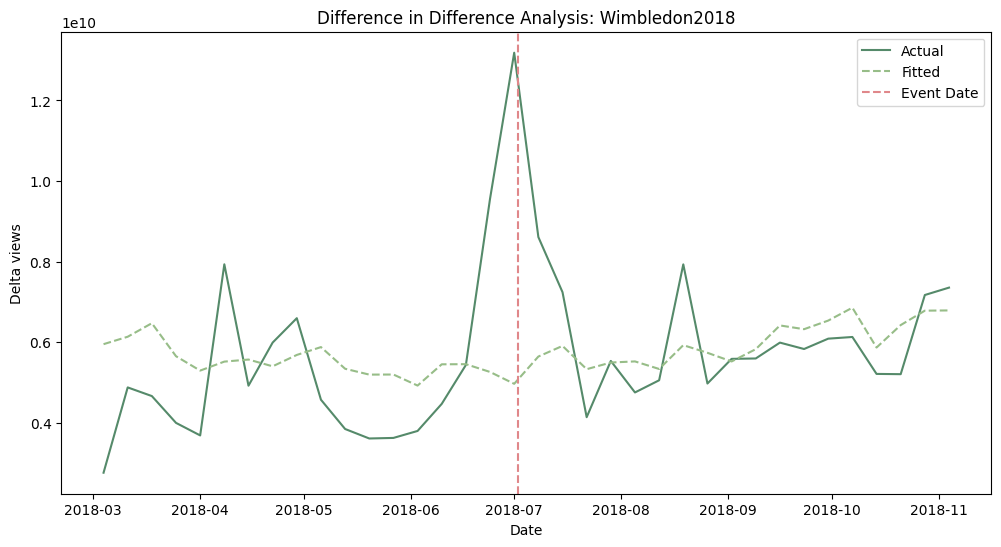

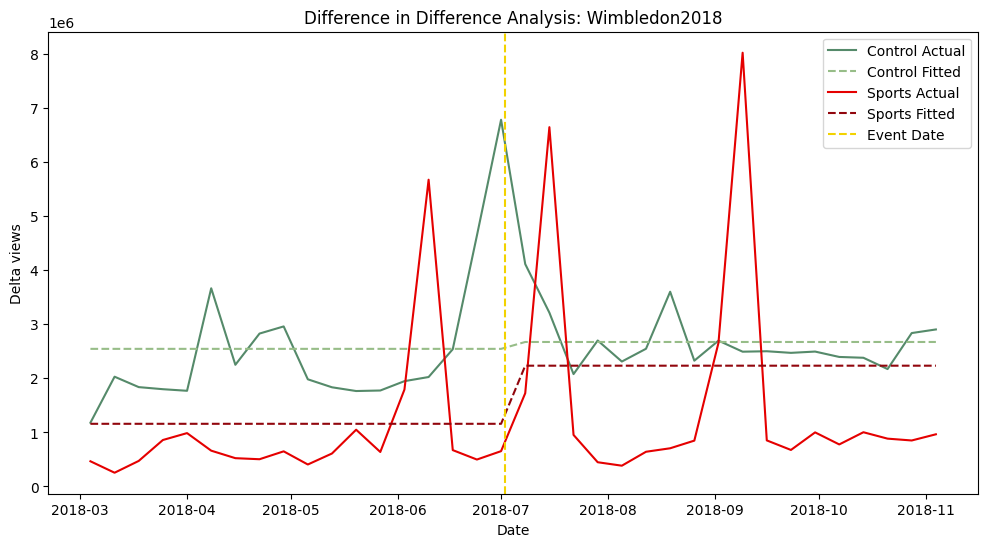

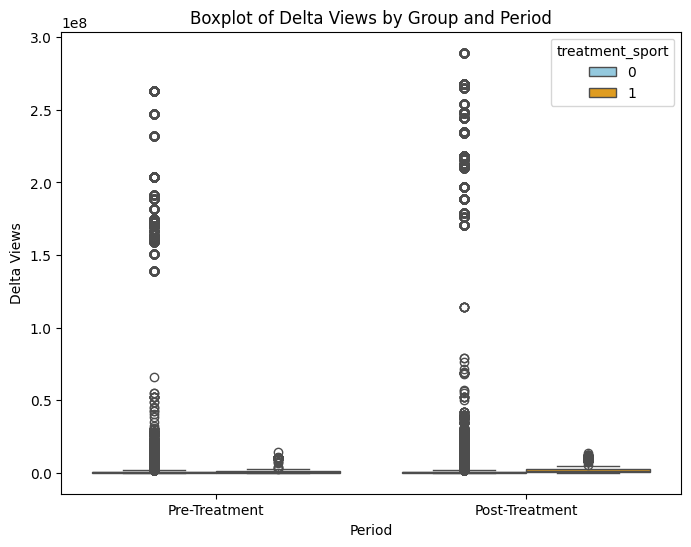

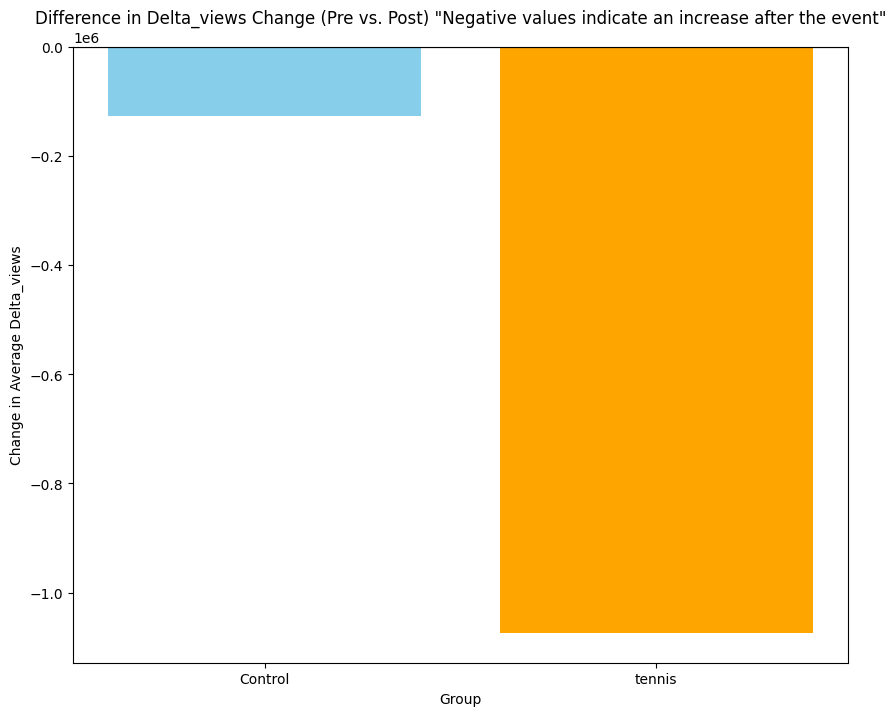

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.702
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           0.000161
Time:                        22:13:21   Log-Likelihood:            -9.8838e+06
No. Observations:              543630   AIC:                         1.977e+07
Df Residuals:                  543626   BIC:                         1.977e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.545e+06   3.72e+04     

In [15]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-07-02')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='Wimbledon2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='tennis',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）

## rugby

(2340291, 3)
(2340291, 2)
DatetimeIndex(['2019-09-28', '2019-09-21', '2019-09-14', '2019-09-07',
               '2019-08-31', '2019-08-24', '2019-08-17', '2019-08-10',
               '2019-08-03', '2019-07-27',
               ...
               '2019-08-10', '2019-07-21', '2019-07-14', '2019-07-07',
               '2019-07-05', '2019-07-01', '2019-06-29', '2019-06-27',
               '2019-06-26', '2019-06-17'],
              dtype='datetime64[ns]', name='upload_date', length=2340291, freq=None)
(2340291, 2)
(2340291, 2)
(548009, 2)
(548009, 4)
Missing values
 delta_views                0
treatment_sport            0
RugbyWorldCupSevens2018    0
interaction                0
dtype: int64


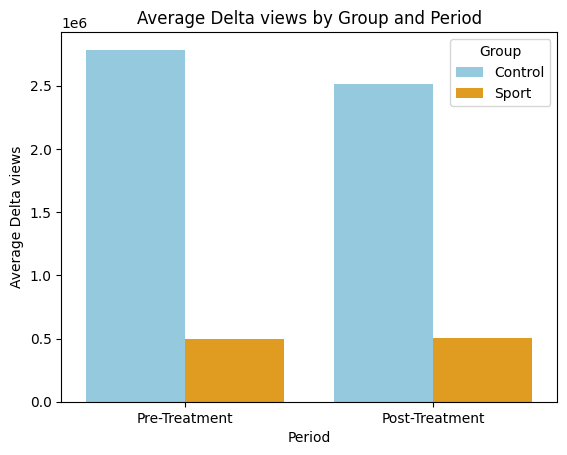

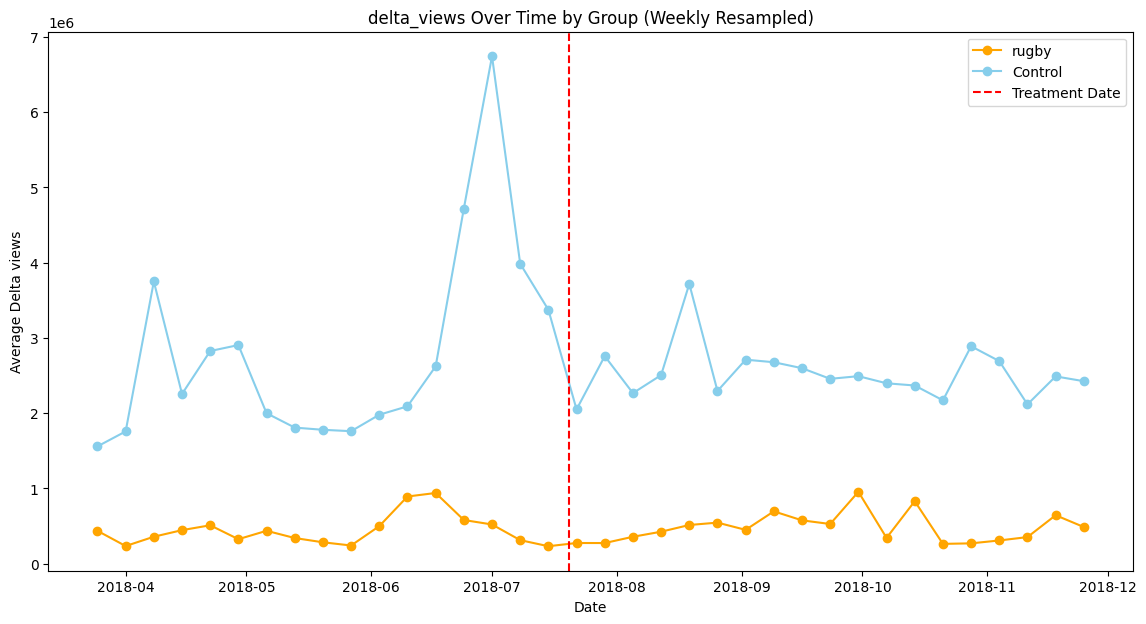

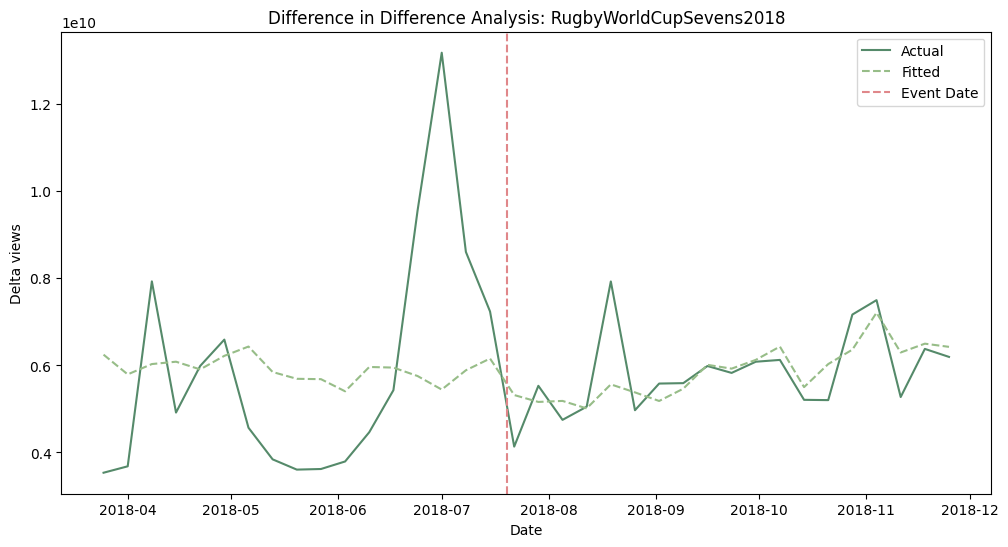

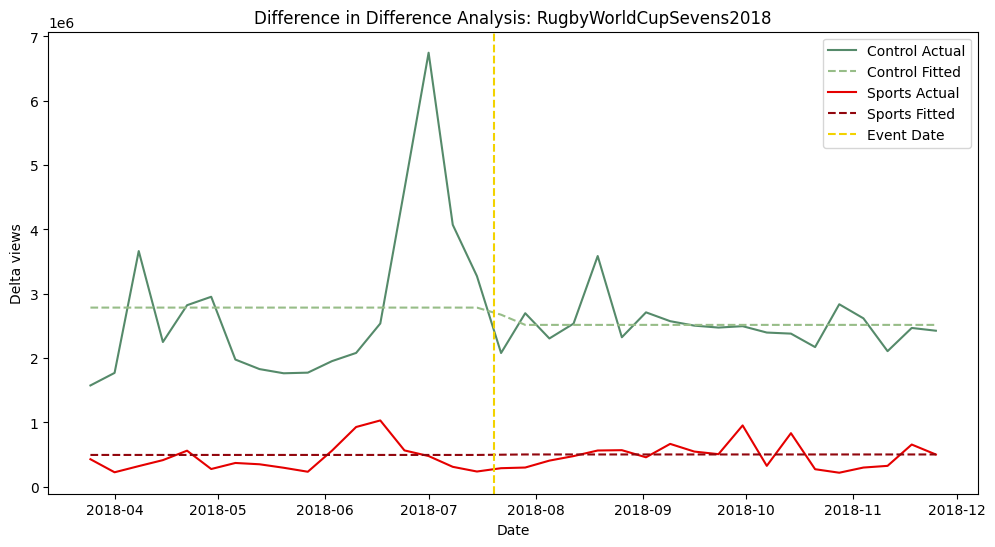

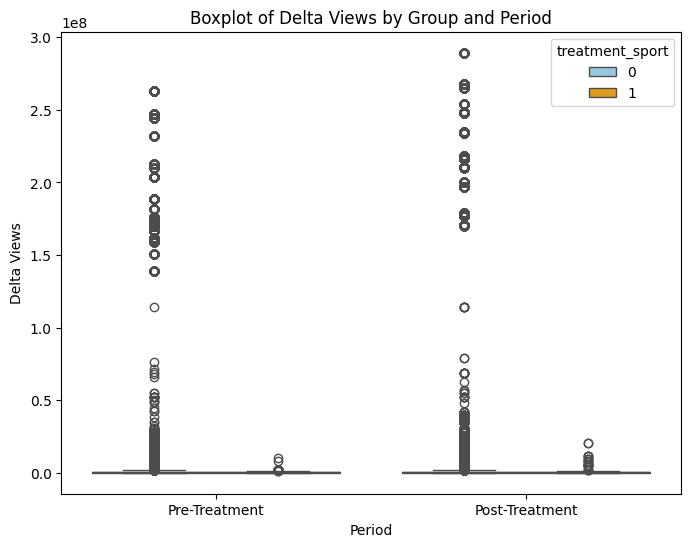

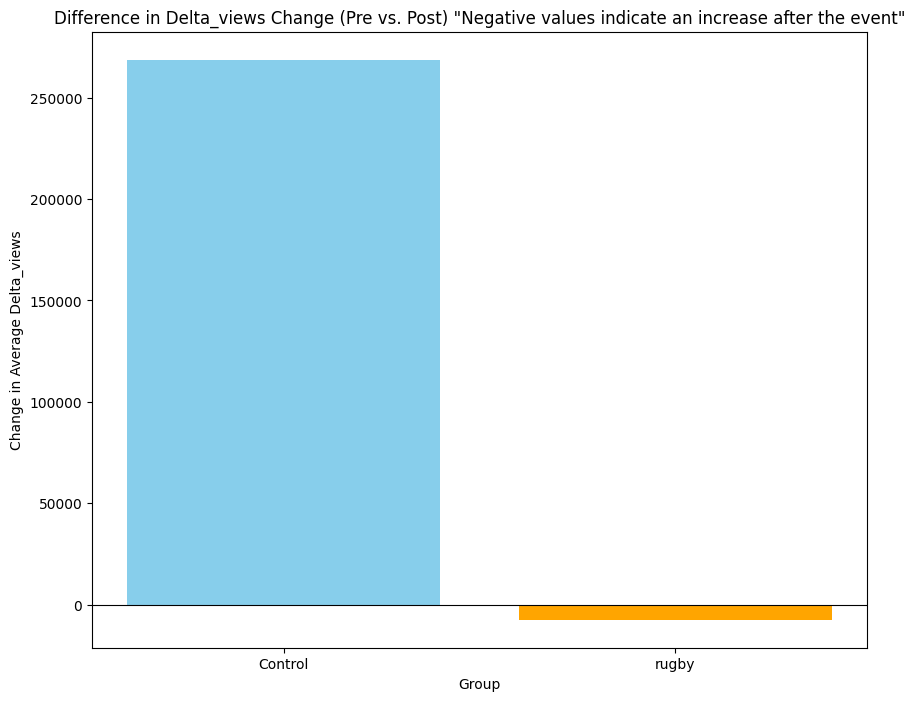

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     20.53
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           2.69e-13
Time:                        22:17:36   Log-Likelihood:            -9.9648e+06
No. Observations:              548009   AIC:                         1.993e+07
Df Residuals:                  548005   BIC:                         1.993e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2

In [16]:
# 必要なライブラリのインポート
import pandas as pd

# 例として、イベントの日付
event_date = pd.to_datetime('2018-07-20')

# `df_orig`はあなたのデータセット（例えばdf_merged_ts_metaなど）
df_orig = df_merged_ts_meta

# 実行
diff_in_diff(df_orig,
             y_column='upload_date',        # 日付を示す列
             x_column='delta_views',        # 解析対象の変数（視聴数の変化）
             event_date=event_date,         # イベントの日付
             event_name='RugbyWorldCupSevens2018',            # イベントを示す列（0/1のフラグ列）
             sport_name='rugby',
             offset_months=4)              # イベント前後の期間（デフォルトで4ヶ月）